In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns 
import re
import pickle
 
import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
import sklearn

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, scale, StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.inspection import permutation_importance

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic,Exponentiation
from sklearn.gaussian_process.kernels import Kernel, Hyperparameter, ConstantKernel
from sklearn.gaussian_process.kernels import GenericKernelMixin

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score  

from sklearn.pipeline import make_pipeline

from sklearn.base import clone

In [3]:
def run_models():
    rf = RandomForestRegressor(n_estimators=10, criterion='absolute_error', 
                               min_samples_split=2, min_samples_leaf=1, max_features=0.3)
    gb = GradientBoostingRegressor(loss='quantile', alpha=0.5,
                                n_estimators=100, max_depth=10,
                                learning_rate=0.25, min_samples_leaf=9,
                                min_samples_split=2)
    rr = Ridge(alpha=0.01)
    lasso = Lasso(alpha=0.02)
    gpr1 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=DotProduct() + WhiteKernel(),
                                    alpha=0.1, n_restarts_optimizer=1)
    gpr2 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=1.0 + 1.0 * Exponentiation(RBF(length_scale=1.0), exponent=2) + 
                                    WhiteKernel(noise_level=0.1), alpha=0.1, n_restarts_optimizer=1)
    gpr3 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=1.0 + 1.0 * Exponentiation(RationalQuadratic(length_scale=1.0, 
                                                                                        alpha=0.01), exponent=2),
                                    alpha=0.001, n_restarts_optimizer=1)
    gpr4 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=1.0 + 1.0 * Exponentiation(Matern(length_scale=1.0, nu=1.5), exponent=2),
                                    alpha=0.01, n_restarts_optimizer=1)
    models = [rf,gb,rr,lasso,gpr1,gpr2,gpr3,gpr4]
    models_names = ["RF","GB","RR","LASSO","gpr1","gpr2","gpr3","gpr4"]
    r2scores=[]
    rmse=[]
    count=0
    for model in models :
        model.fit(X,Y)
        predicted = model.predict(X_test)
        r2=sklearn.metrics.r2_score(Y_test, predicted)
        Y_unscaled = scaler.inverse_transform(np.array(Y_test).reshape(-1,1))
        predicted_unscaled = scaler.inverse_transform(np.array(predicted).reshape(-1,1))
        r2scores.append(r2)
        err=np.sqrt(mean_squared_error(Y_test,predicted))
        err_unscaled=np.sqrt(mean_squared_error(Y_unscaled,predicted_unscaled))
        rmse.append(err_unscaled)
        print(models_names[count],r2)
        print("RMSE: ",err)
        print("RMSE unscaled: ",err_unscaled)
        print("----------------------------------------")
        fig, ax = plt.subplots()
        ax.scatter(Y_unscaled, predicted_unscaled)
        ax.plot([Y_unscaled.min(), predicted_unscaled.max()], [Y_unscaled.min(), predicted_unscaled.max()], 'r--', lw=1)
        #for i in range(len(Y_test)):
        #    plt.annotate(text[i], (Y_test[i], predicted[i]))
        ax.set_xlabel("Calculated, ZPE (kJ/mol))",fontsize= 20)
        ax.set_ylabel("Predicted, ZPE (kJ/mol))",fontsize= 20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        ax.tick_params(direction='in', length=10, width=2)
        for axis in ['top','bottom','left','right']:
              ax.spines[axis].set_linewidth(2)
        #plt.savefig('kl_train.eps', format='eps', bbox_inches='tight',pad_inches = 0)
        plt.show()
        count+=1
    plt.rcdefaults()
    fig, ax = plt.subplots()

    x_pos = np.arange(len(models_names))
    ax.bar(x_pos, r2scores, align='center')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(models_names)
    ax.set_ylabel('R2 Score')
    #plt.savefig('imp.eps', format='eps')
    plt.show()

In [4]:
def get_RF_feature_importance():
    features= X
    feature_list = list(features.columns)
    rf = RandomForestRegressor(n_estimators= 15, random_state=1)
    rf.fit(X , Y)

    # Get numerical feature importances
    importances = list(rf.feature_importances_)      
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, 
                           importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances 
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [5]:
target = 'Coeff_A'

# Standard Scaling

In [6]:
df_test = pd.read_csv('scaled_standard_'+target+'_test.csv', encoding='cp1252')
df_train = pd.read_csv('scaled_standard_'+target+'_train.csv', encoding='cp1252')  

In [7]:
df_test.columns.values

array(['Name', 'density', 'mean_A2B', 'mean_A2X', 'mean_B2X', 'mean_X2X',
       'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh', 'TF', 'OF',
       'A_Z', 'B_Z', 'X_Z', 'A_G', 'B_G', 'X_G', 'A_IEI', 'B_IEI',
       'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII', 'A_EA', 'B_EA', 'X_EA',
       'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA', 'B_ChiA', 'A_Rvdw',
       'B_Rvdw', 'X_Rvdw', 'B_Rc', 'B_Ra', 'A_MP', 'B_MP', 'A_Rho',
       'B_Rho', 'X_Rho', 'B_MV', 'X_MV', 'B_Hf', 'A_Kappa', 'B_Kappa',
       'X_Kappa', 'A_CvM', 'B_CvM', 'A_B', 'B_B', 'B_MendeleevNo',
       'Coeff_A'], dtype=object)

In [8]:
df_train.columns.values

array(['Name', 'density', 'mean_A2B', 'mean_A2X', 'mean_B2X', 'mean_X2X',
       'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh', 'TF', 'OF',
       'A_Z', 'B_Z', 'X_Z', 'A_G', 'B_G', 'X_G', 'A_IEI', 'B_IEI',
       'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII', 'A_EA', 'B_EA', 'X_EA',
       'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA', 'B_ChiA', 'A_Rvdw',
       'B_Rvdw', 'X_Rvdw', 'B_Rc', 'B_Ra', 'A_MP', 'B_MP', 'A_Rho',
       'B_Rho', 'X_Rho', 'B_MV', 'X_MV', 'B_Hf', 'A_Kappa', 'B_Kappa',
       'X_Kappa', 'A_CvM', 'B_CvM', 'A_B', 'B_B', 'B_MendeleevNo',
       'Coeff_A'], dtype=object)

In [9]:
df_test.fillna(0, inplace= True)
df_train.fillna(0, inplace= True)

In [10]:
with open("standard_"+target+"_scaler.pkl", 'rb') as file:
        scaler = pickle.load(file)

In [11]:
#df_train.reset_index(inplace = True)
#df_test.reset_index(inplace = True)
#df_train=df_train.drop('index',axis=1)
#df_test=df_test.drop('index',axis=1)

# divide into X_train, y_train, X_test, y_test
Y = df_train[target] 
X = df_train.drop([target,'Name'], axis=1)

Y_test = df_test[target]
X_test = df_test.drop([target,'Name'], axis=1)

RF 0.8532140086585167
RMSE:  0.3960015597445724
RMSE unscaled:  1.0983300310106818e-08
----------------------------------------


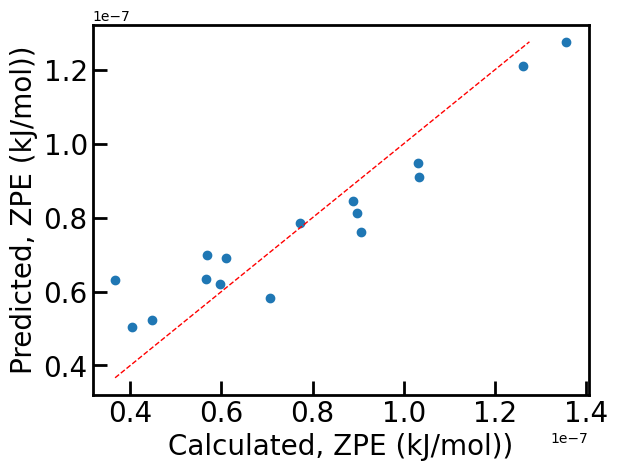

GB 0.8070206814598195
RMSE:  0.4540565820159731
RMSE unscaled:  1.2593485241014713e-08
----------------------------------------


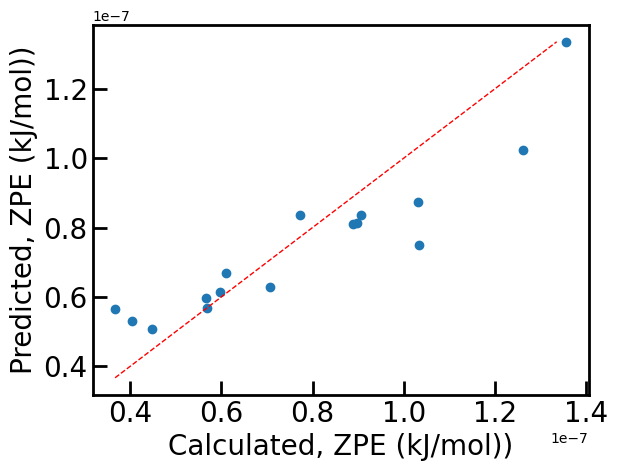

RR 0.7850218298768639
RMSE:  0.4792385796094463
RMSE unscaled:  1.3291920474845368e-08
----------------------------------------


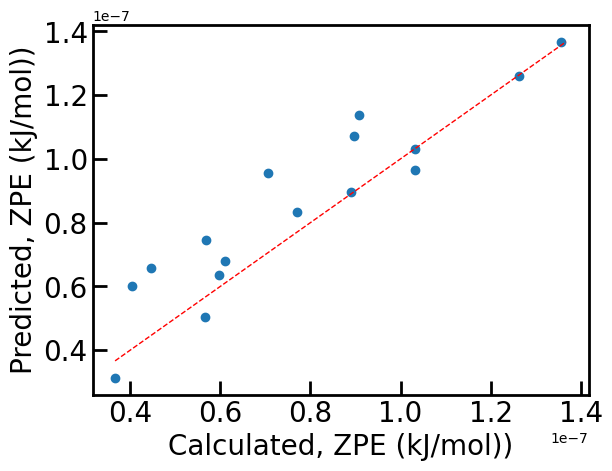

LASSO 0.9215141006927199
RMSE:  0.2895678961682743
RMSE unscaled:  8.031309689369413e-09
----------------------------------------


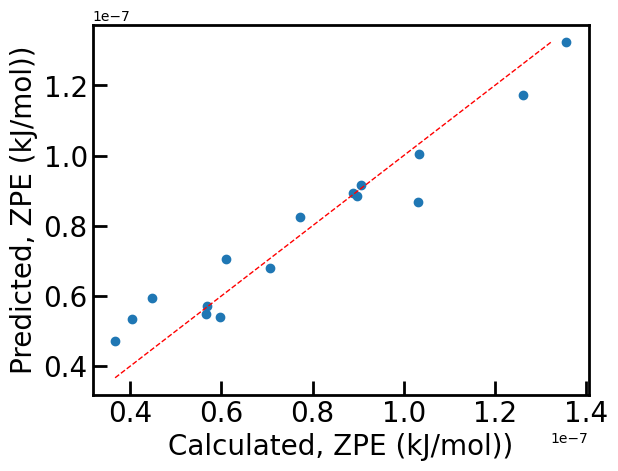

gpr1 0.9471565579622035
RMSE:  0.23760202655959883
RMSE unscaled:  6.590010437527873e-09
----------------------------------------


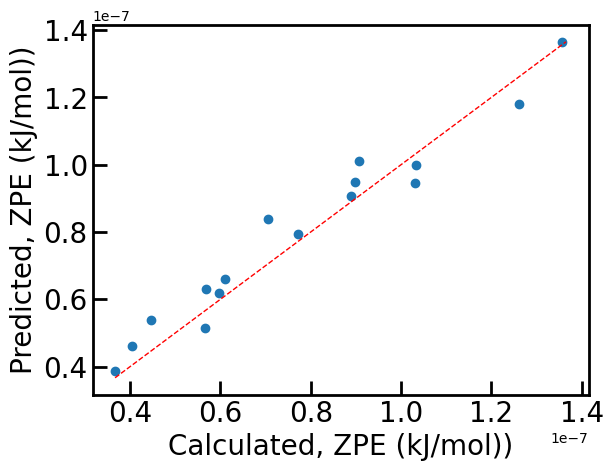

gpr2 0.9446469543856997
RMSE:  0.2431785990132134
RMSE unscaled:  6.744679449434354e-09
----------------------------------------


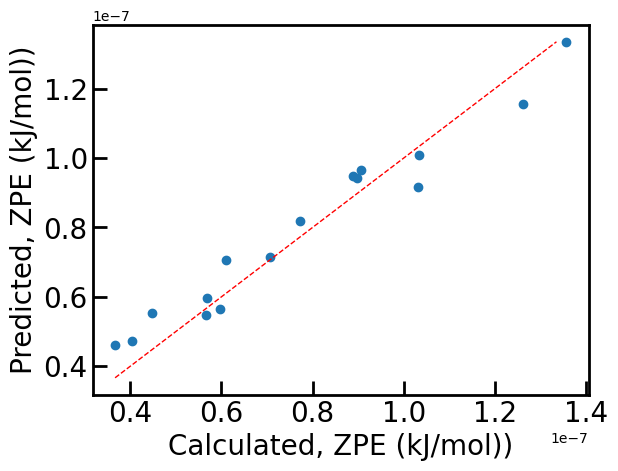

gpr3 0.9672263800328944
RMSE:  0.18711853047176685
RMSE unscaled:  5.189825552916795e-09
----------------------------------------


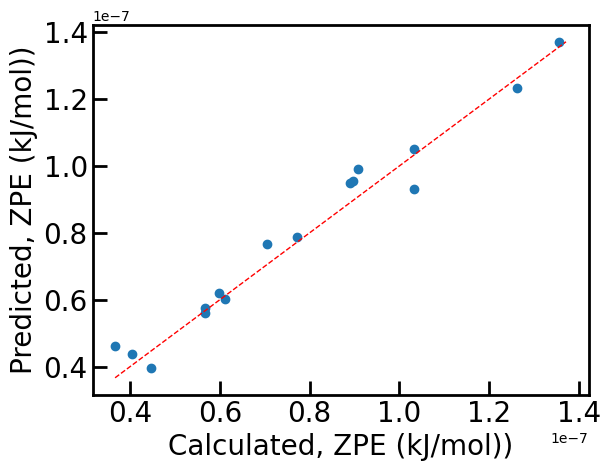

gpr4 0.9763240984611155
RMSE:  0.15904054451476526
RMSE unscaled:  4.411068640778302e-09
----------------------------------------


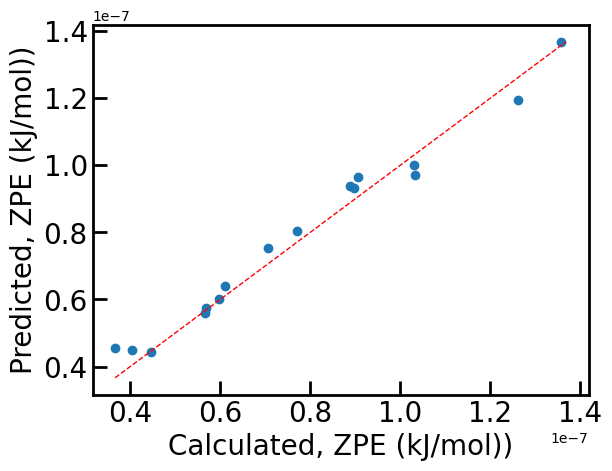

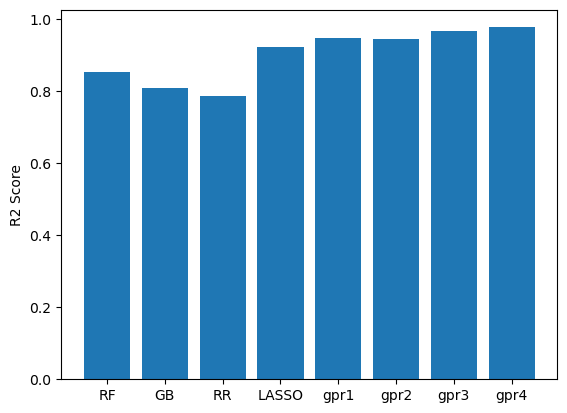

In [12]:
run_models()

In [13]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature       Score
1   mean_A2B  116.020547
26      X_EA  102.827848
14       X_Z   85.709577
23    X_IEII   82.228015
34    X_Rvdw   72.130297
4   mean_X2X   57.533597
32    A_Rvdw   43.418075
2   mean_A2X   41.138934
18     A_IEI   29.229299
9      E_coh   28.569477
30    A_ChiA   28.149536
6    std_A2X   13.817586
27    A_ChiP   13.426174
24      A_EA   12.944525
44      B_Hf   12.679046
7    std_B2X   11.458588
17       X_G   11.132373
38      B_MP   10.670370
47   X_Kappa    9.549651
37      A_MP    9.365081
46   B_Kappa    8.332838
13       B_Z    8.302309
11        OF    8.213709
45   A_Kappa    7.835195
12       A_Z    7.259730
36      B_Ra    6.424021
40     B_Rho    5.360087
48     A_CvM    5.202146
43      X_MV    4.971144
15       A_G    4.646239


In [14]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 'X_Z', 'X_IEII', 'X_Rvdw', 'mean_X2X',
       'A_Rvdw', 'mean_A2X', 'A_IEI', 'E_coh', 'A_ChiA', 'std_A2X',
       'A_ChiP', 'A_EA', 'B_Hf', 'std_B2X', 'X_G', 'B_MP', 'X_Kappa',
       'A_MP', 'B_Kappa', 'B_Z', 'OF', 'A_Kappa', 'A_Z', 'B_Ra', 'B_Rho',
       'A_CvM', 'X_MV', 'A_G', 'B_EA', 'A_B', 'std_X2X', 'B_CvM',
       'B_ChiP', 'TF', 'std_A2B', 'X_IEI', 'B_IEI', 'B_MV'], dtype=object)

In [15]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(40,'Score')['Feature'].values]

RF 0.8791854846738605
RMSE:  0.35926437092363356
RMSE unscaled:  9.964376097712975e-09
----------------------------------------


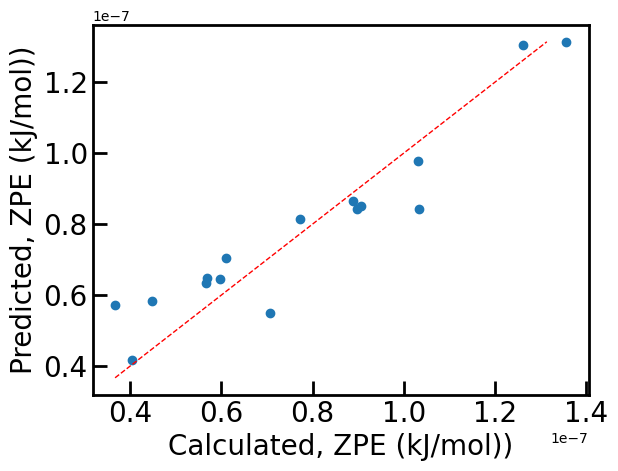

GB 0.8900882595201095
RMSE:  0.3426704334431027
RMSE unscaled:  9.504134984538157e-09
----------------------------------------


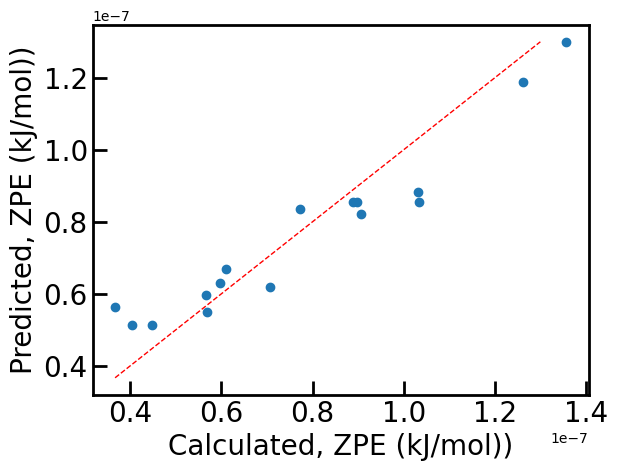

RR 0.9179639993252908
RMSE:  0.2960443870597664
RMSE unscaled:  8.210938386950331e-09
----------------------------------------


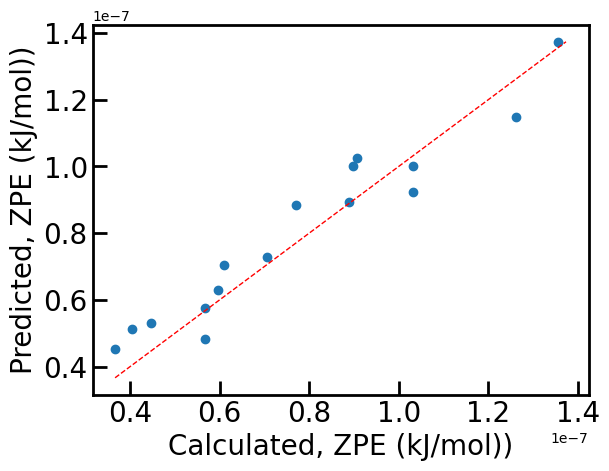

LASSO 0.9216802226626122
RMSE:  0.28926128650625504
RMSE unscaled:  8.022805717824177e-09
----------------------------------------


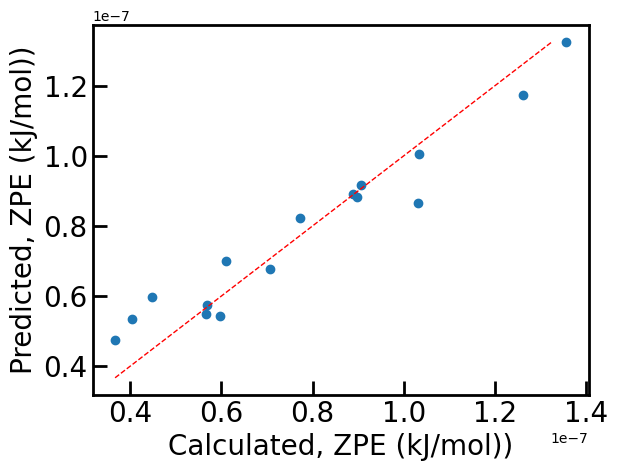

gpr1 0.931148861178999
RMSE:  0.2712127831381816
RMSE unscaled:  7.522221495965586e-09
----------------------------------------


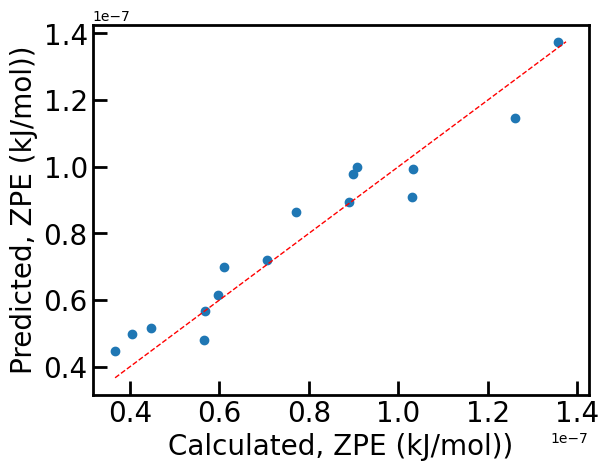

gpr2 0.9427813806282581
RMSE:  0.2472425867028187
RMSE unscaled:  6.857396170248035e-09
----------------------------------------


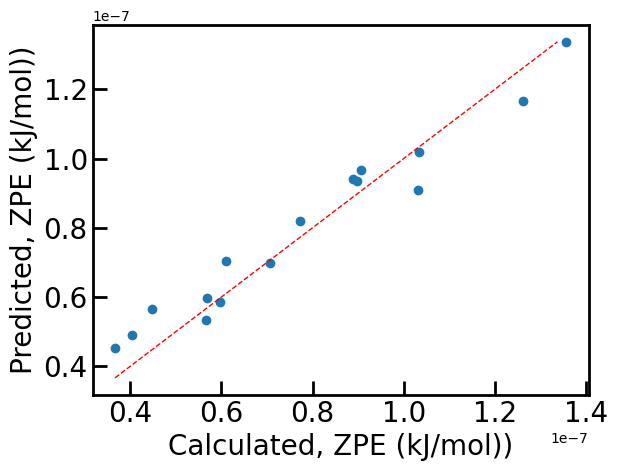

gpr3 0.9518845685042353
RMSE:  0.22672362869239757
RMSE unscaled:  6.288292659584363e-09
----------------------------------------


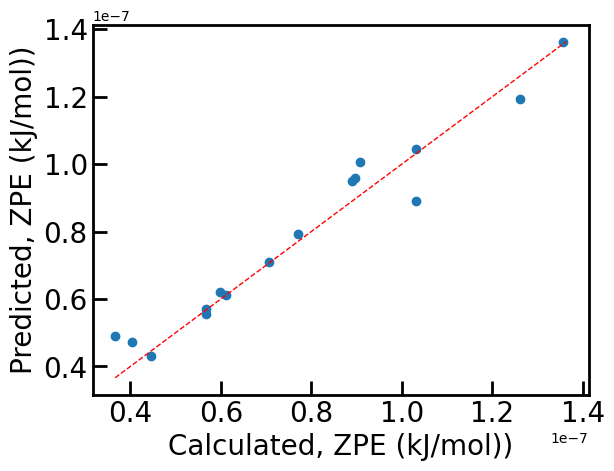

gpr4 0.9678811474126664
RMSE:  0.1852399275455248
RMSE unscaled:  5.137721565963634e-09
----------------------------------------


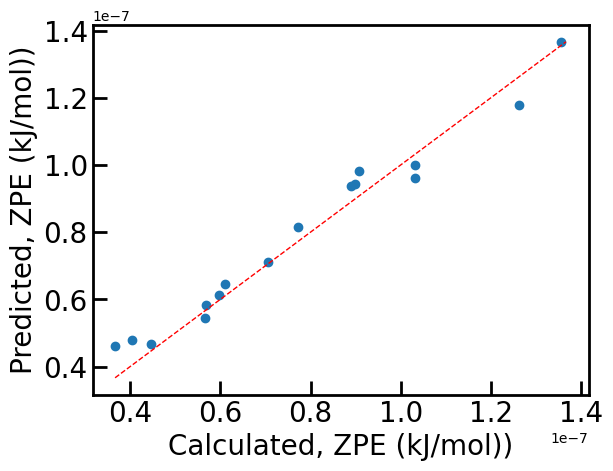

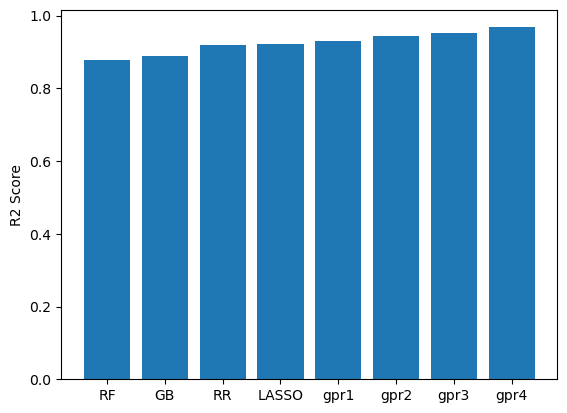

In [16]:
run_models()

In [17]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 'X_Z', 'X_IEII', 'X_Rvdw', 'mean_X2X',
       'A_Rvdw', 'mean_A2X', 'A_IEI', 'E_coh', 'A_ChiA', 'std_A2X',
       'A_ChiP', 'A_EA', 'B_Hf', 'std_B2X', 'X_G', 'B_MP', 'X_Kappa',
       'A_MP', 'B_Kappa', 'B_Z', 'OF', 'A_Kappa', 'A_Z', 'B_Ra', 'B_Rho',
       'A_CvM', 'X_MV', 'A_G'], dtype=object)

In [18]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(30,'Score')['Feature'].values]

RF 0.8446758645643057
RMSE:  0.40735594968576416
RMSE unscaled:  1.1298219965076367e-08
----------------------------------------


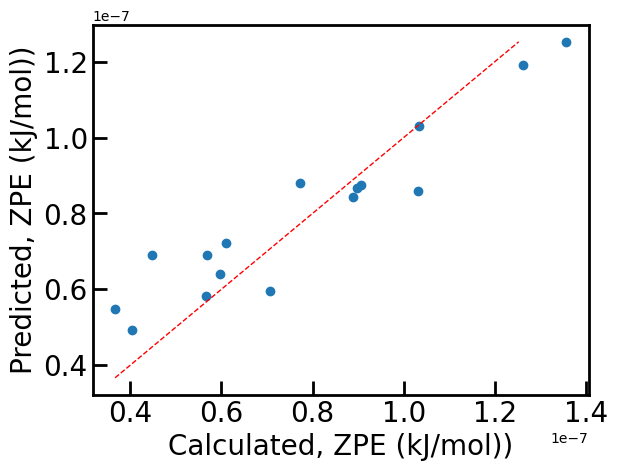

GB 0.8852301094058819
RMSE:  0.35016164608121314
RMSE unscaled:  9.711907494687623e-09
----------------------------------------


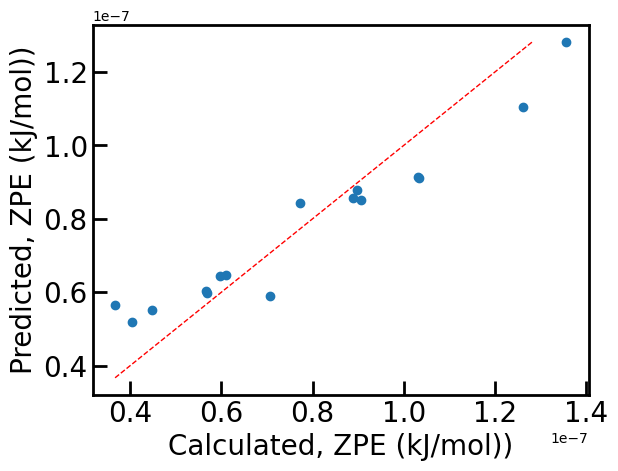

RR 0.9116209734047767
RMSE:  0.3072763945362161
RMSE unscaled:  8.52246370336268e-09
----------------------------------------


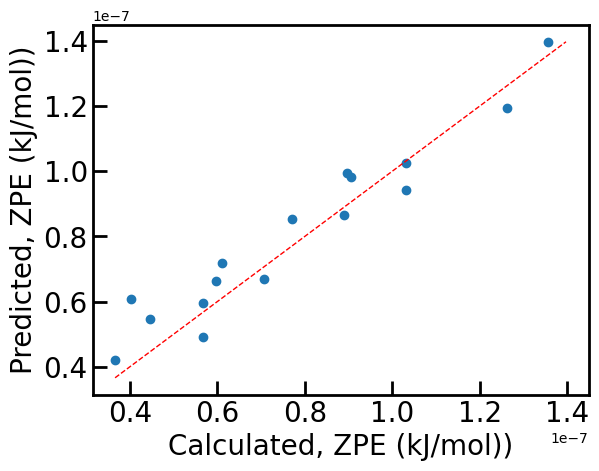

LASSO 0.9368916029696028
RMSE:  0.2596558824728174
RMSE unscaled:  7.201685105291665e-09
----------------------------------------


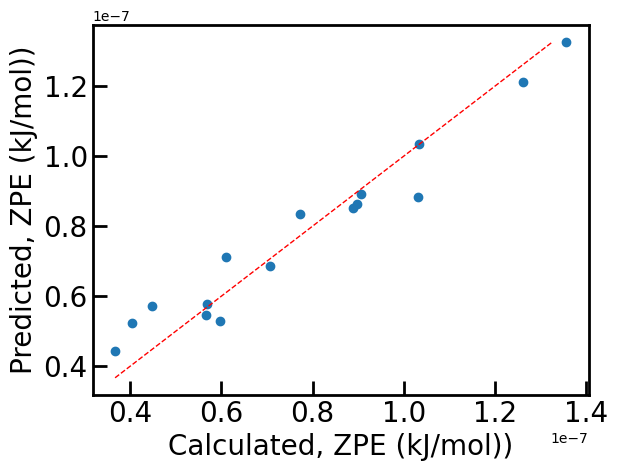

gpr1 0.9240249164464885
RMSE:  0.28489851435550606
RMSE unscaled:  7.901802061305363e-09
----------------------------------------


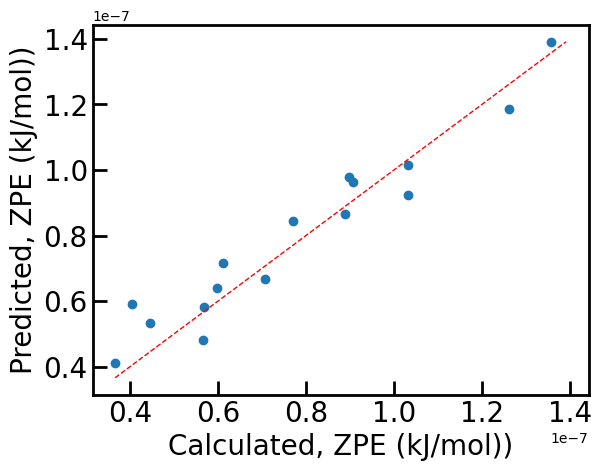

gpr2 0.9545327961359571
RMSE:  0.22039600335761922
RMSE unscaled:  6.1127928222944845e-09
----------------------------------------


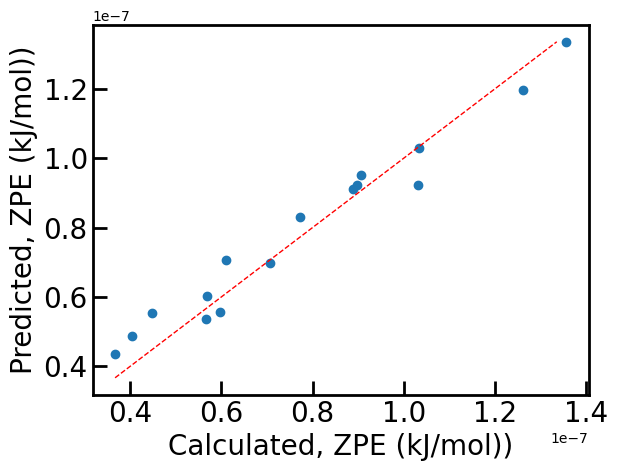

gpr3 0.9340335064214551
RMSE:  0.26547051439683
RMSE unscaled:  7.362956815068155e-09
----------------------------------------


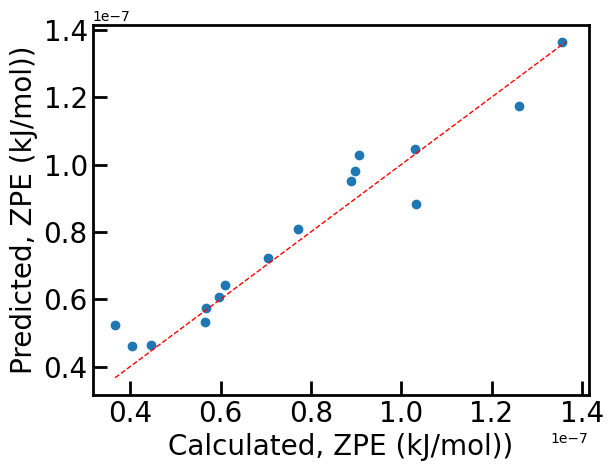

gpr4 0.9595281584989714
RMSE:  0.20793666496165025
RMSE unscaled:  5.767226872108733e-09
----------------------------------------


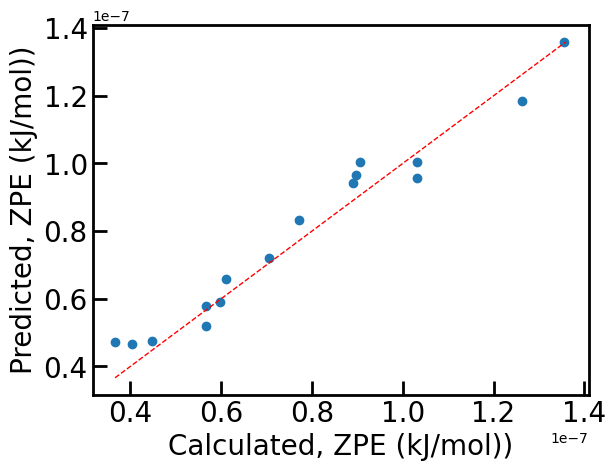

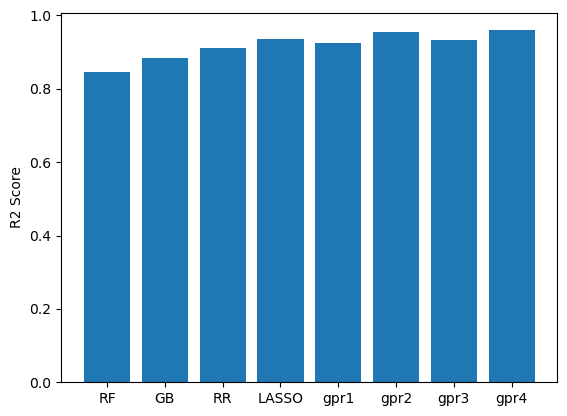

In [19]:
run_models()

In [20]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 'X_Z', 'X_IEII', 'X_Rvdw', 'mean_X2X',
       'A_Rvdw', 'mean_A2X', 'A_IEI', 'E_coh', 'A_ChiA', 'std_A2X',
       'A_ChiP', 'A_EA', 'B_Hf', 'std_B2X', 'X_G', 'B_MP', 'X_Kappa',
       'A_MP'], dtype=object)

In [21]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(20,'Score')['Feature'].values]

RF 0.8301786354822837
RMSE:  0.4259422830990837
RMSE unscaled:  1.1813721170864384e-08
----------------------------------------


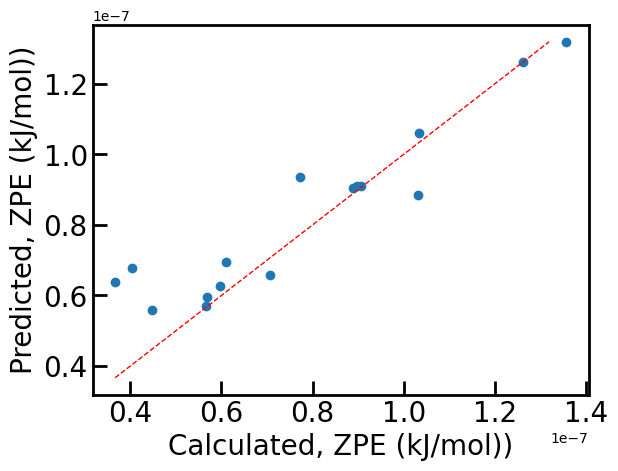

GB 0.8071656527345055
RMSE:  0.4538860001913824
RMSE unscaled:  1.2588754069228081e-08
----------------------------------------


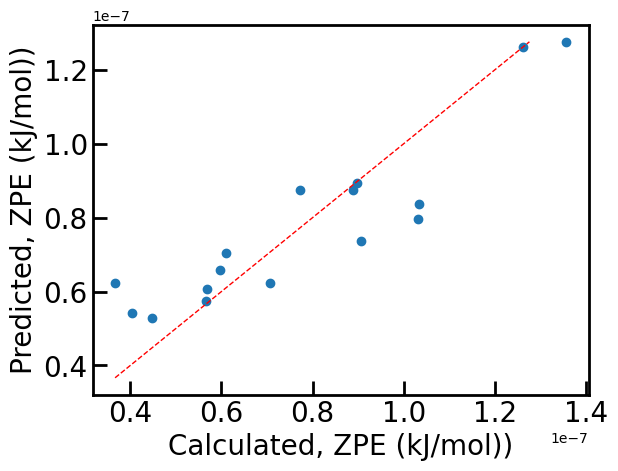

RR 0.9026869368022314
RMSE:  0.3224335041017026
RMSE unscaled:  8.942853679347397e-09
----------------------------------------


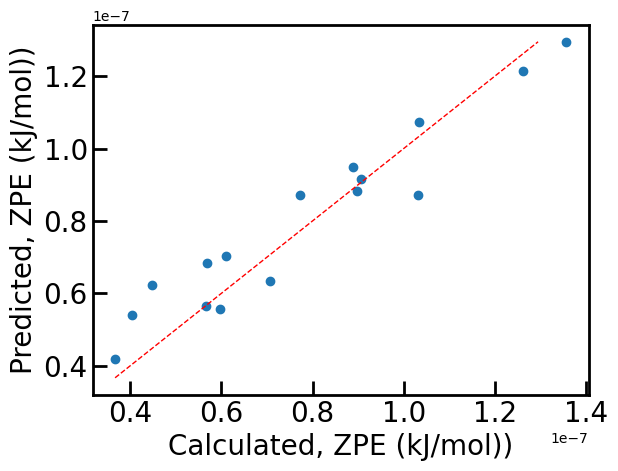

LASSO 0.8864373655895823
RMSE:  0.34831511483888233
RMSE unscaled:  9.660693031846628e-09
----------------------------------------


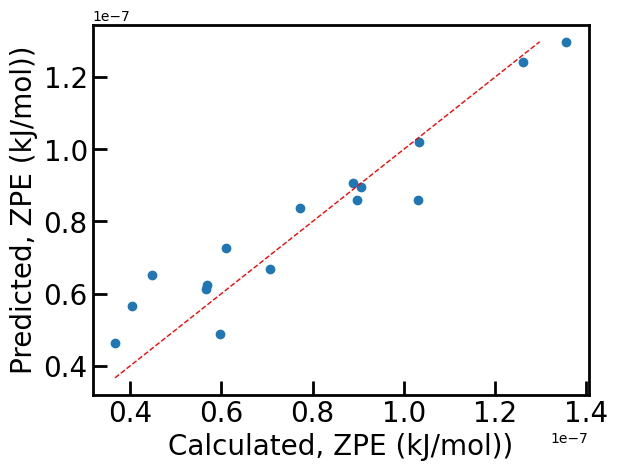

gpr1 0.905757941260078
RMSE:  0.31730504247521435
RMSE unscaled:  8.800613244211453e-09
----------------------------------------


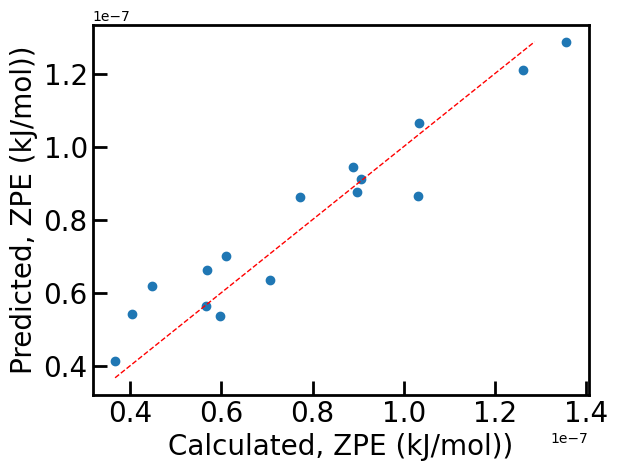

gpr2 0.903362393519552
RMSE:  0.32131253888882466
RMSE unscaled:  8.911763151375329e-09
----------------------------------------


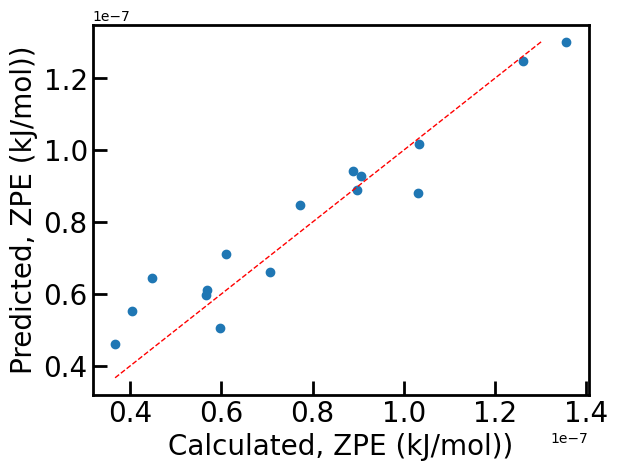

gpr3 0.9257353770472926
RMSE:  0.28167323496086216
RMSE unscaled:  7.812347332394137e-09
----------------------------------------


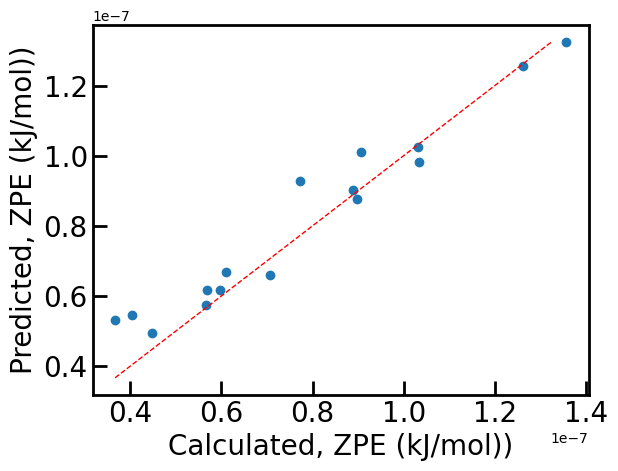

gpr4 0.9352368479942456
RMSE:  0.26303805235270533
RMSE unscaled:  7.295491269879923e-09
----------------------------------------


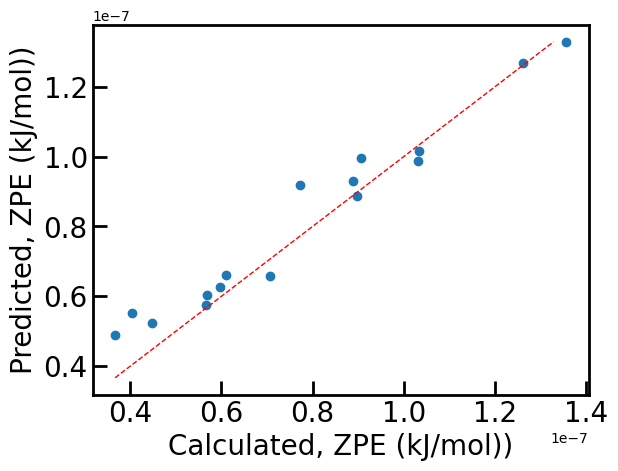

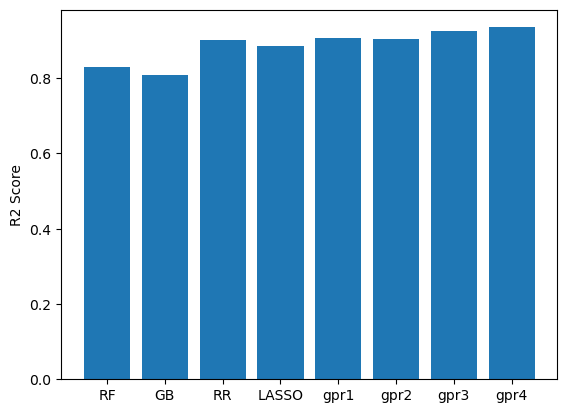

In [22]:
run_models()

In [23]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 'X_Z', 'X_IEII', 'X_Rvdw', 'mean_X2X',
       'A_Rvdw', 'mean_A2X', 'A_IEI', 'E_coh'], dtype=object)

In [24]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(10,'Score')['Feature'].values]

RF 0.8818696681464634
RMSE:  0.3552509953086405
RMSE unscaled:  9.853063127973259e-09
----------------------------------------


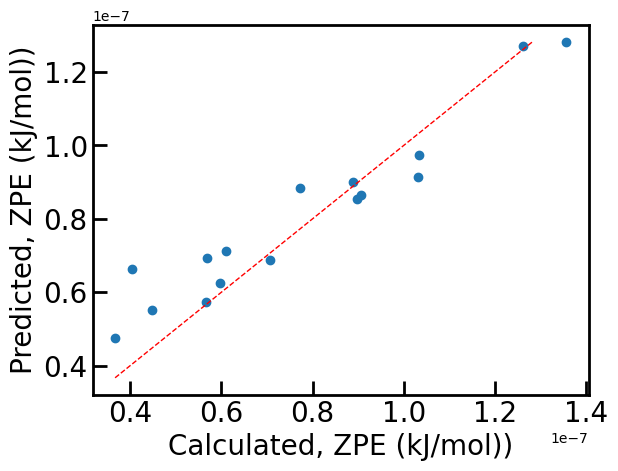

GB 0.8124812901070627
RMSE:  0.44758641304989405
RMSE unscaled:  1.2414031885180918e-08
----------------------------------------


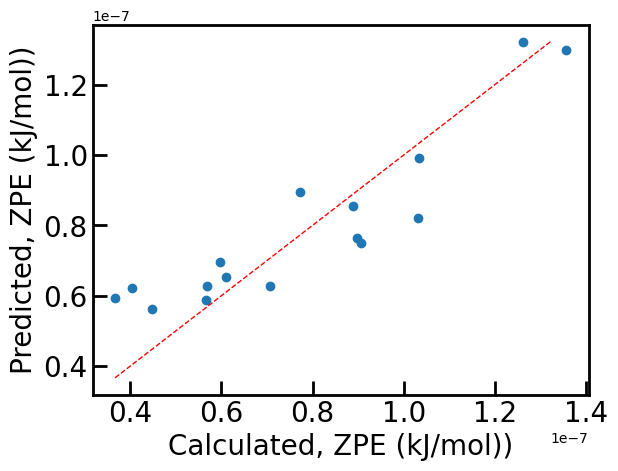

RR 0.9000502693411083
RMSE:  0.3267724282965099
RMSE unscaled:  9.063195900941414e-09
----------------------------------------


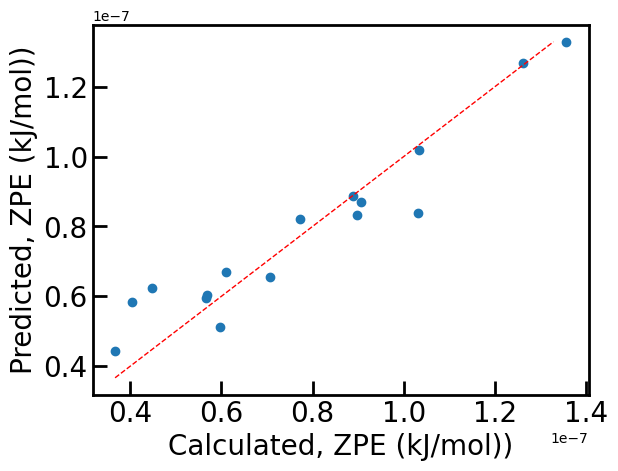

LASSO 0.8763236793566659
RMSE:  0.36349452148562206
RMSE unscaled:  1.0081701428474944e-08
----------------------------------------


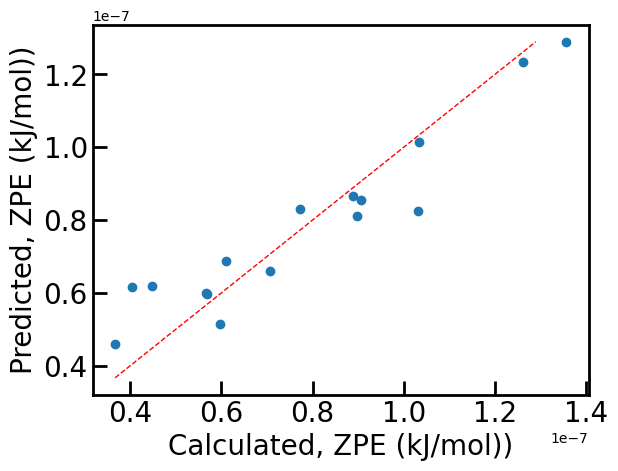

gpr1 0.8996570153034386
RMSE:  0.3274146432536379
RMSE unscaled:  9.08100805234387e-09
----------------------------------------


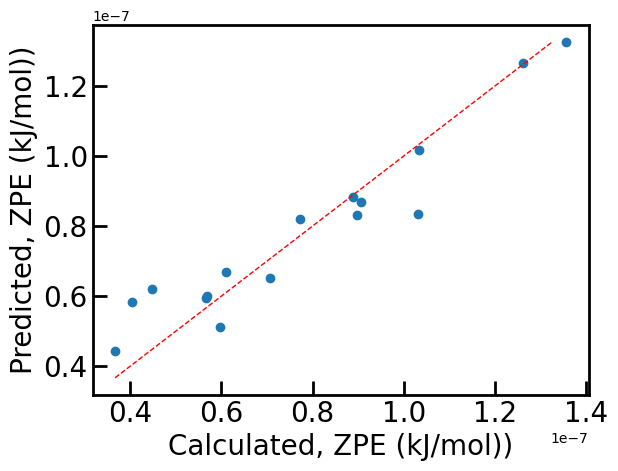

gpr2 0.9027795533532422
RMSE:  0.3222800314493969
RMSE unscaled:  8.938597038967622e-09
----------------------------------------


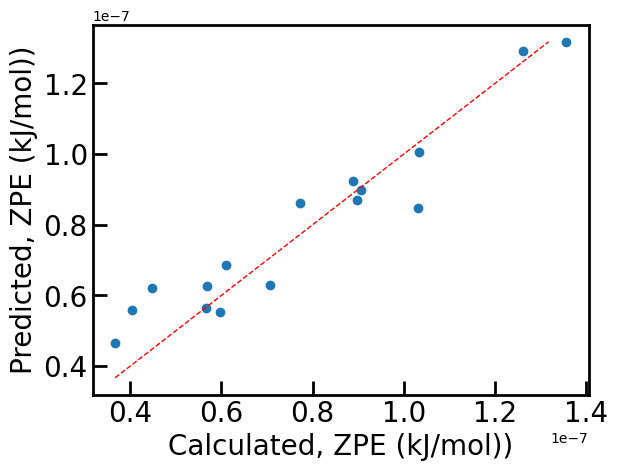

gpr3 0.9494541373854237
RMSE:  0.23237927781213708
RMSE unscaled:  6.445154902174409e-09
----------------------------------------


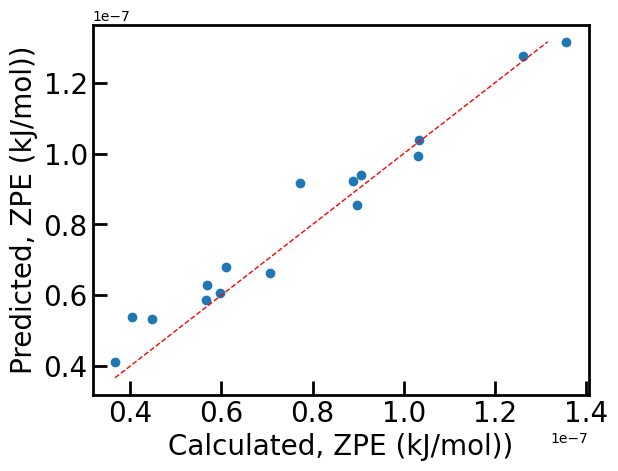

gpr4 0.9449027933477834
RMSE:  0.24261596858856388
RMSE unscaled:  6.729074614641494e-09
----------------------------------------


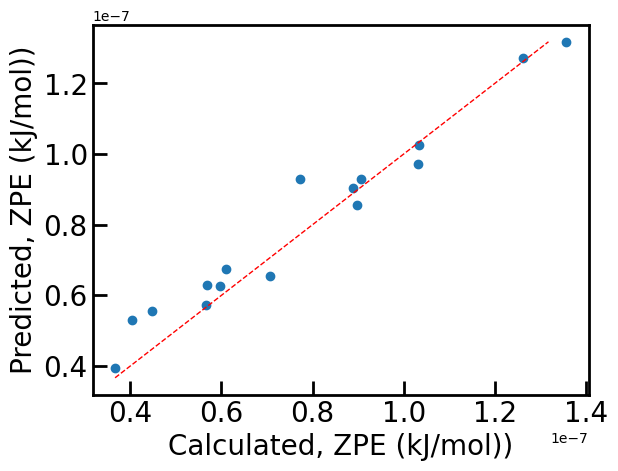

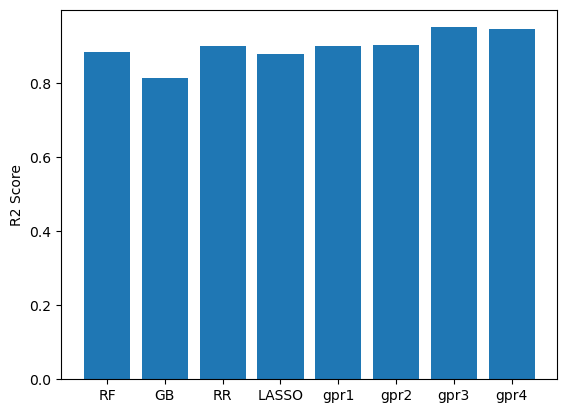

In [25]:
run_models()

# Min-Max scaling

In [26]:
df_test = pd.read_csv('scaled_minmax_'+target+'_test.csv', encoding='cp1252')
df_train = pd.read_csv('scaled_minmax_'+target+'_train.csv', encoding='cp1252')   

In [27]:
df_test.columns.values

array(['Name', 'density', 'mean_A2B', 'mean_A2X', 'mean_B2X', 'mean_X2X',
       'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh', 'TF', 'OF',
       'A_Z', 'B_Z', 'X_Z', 'A_G', 'B_G', 'X_G', 'A_IEI', 'B_IEI',
       'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII', 'A_EA', 'B_EA', 'X_EA',
       'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA', 'B_ChiA', 'A_Rvdw',
       'B_Rvdw', 'X_Rvdw', 'B_Rc', 'B_Ra', 'A_MP', 'B_MP', 'A_Rho',
       'B_Rho', 'X_Rho', 'B_MV', 'X_MV', 'B_Hf', 'A_Kappa', 'B_Kappa',
       'X_Kappa', 'A_CvM', 'B_CvM', 'A_B', 'B_B', 'B_MendeleevNo',
       'Coeff_A'], dtype=object)

In [28]:
df_train.columns.values

array(['Name', 'density', 'mean_A2B', 'mean_A2X', 'mean_B2X', 'mean_X2X',
       'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh', 'TF', 'OF',
       'A_Z', 'B_Z', 'X_Z', 'A_G', 'B_G', 'X_G', 'A_IEI', 'B_IEI',
       'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII', 'A_EA', 'B_EA', 'X_EA',
       'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA', 'B_ChiA', 'A_Rvdw',
       'B_Rvdw', 'X_Rvdw', 'B_Rc', 'B_Ra', 'A_MP', 'B_MP', 'A_Rho',
       'B_Rho', 'X_Rho', 'B_MV', 'X_MV', 'B_Hf', 'A_Kappa', 'B_Kappa',
       'X_Kappa', 'A_CvM', 'B_CvM', 'A_B', 'B_B', 'B_MendeleevNo',
       'Coeff_A'], dtype=object)

In [29]:
df_test.fillna(0, inplace= True)
df_train.fillna(0, inplace= True)

In [30]:
with open("minmax_"+target+"_scaler.pkl", 'rb') as file:
        scaler = pickle.load(file)

In [31]:
#df_train.reset_index(inplace = True)
#df_test.reset_index(inplace = True)
#df_train=df_train.drop('index',axis=1)
#df_test=df_test.drop('index',axis=1)
# divide into X_train, y_train, X_test, y_test
Y = df_train[target] 
X = df_train.drop([target,'Name'], axis=1)

Y_test = df_test[target]
X_test = df_test.drop([target,'Name'], axis=1)

RF 0.9030879928062481
RMSE:  0.08686798512193958
RMSE unscaled:  8.92440657665111e-09
----------------------------------------


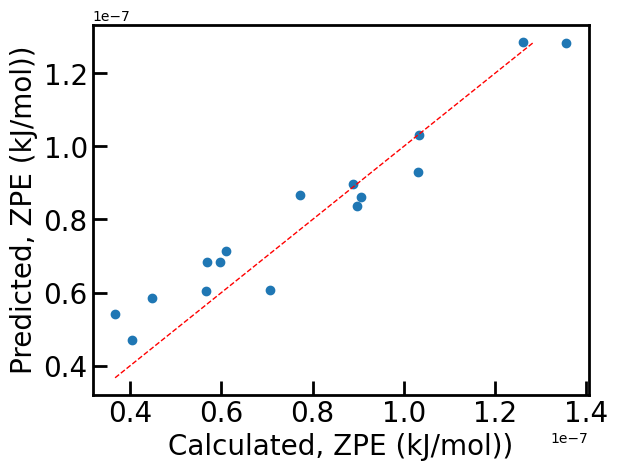

GB 0.8328551517743044
RMSE:  0.11408208545739205
RMSE unscaled:  1.172025473256759e-08
----------------------------------------


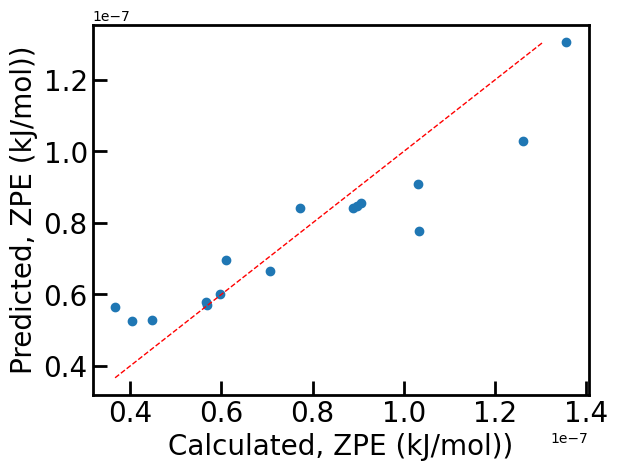

RR 0.9349879425677856
RMSE:  0.07114885398777712
RMSE unscaled:  7.309497274034739e-09
----------------------------------------


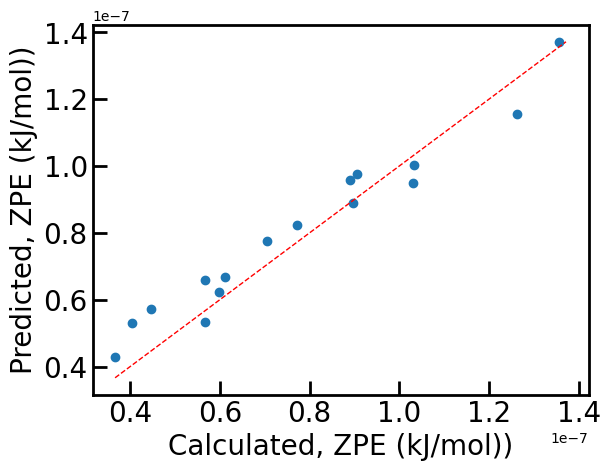

LASSO 0.6878442865134009
RMSE:  0.15590376316394786
RMSE unscaled:  1.601681640654965e-08
----------------------------------------


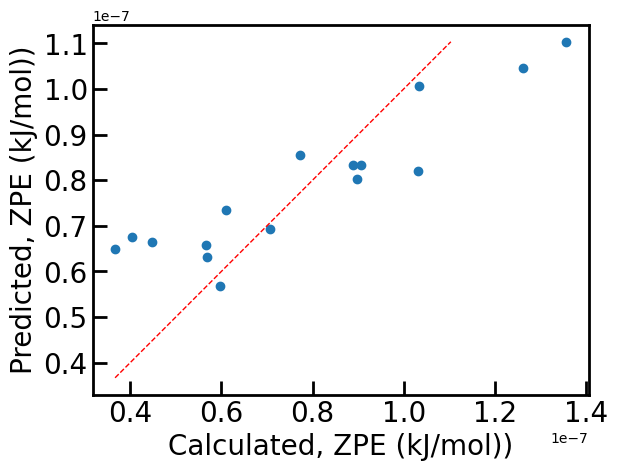

gpr1 0.9331997959153974
RMSE:  0.07212068594422605
RMSE unscaled:  7.409338699979612e-09
----------------------------------------


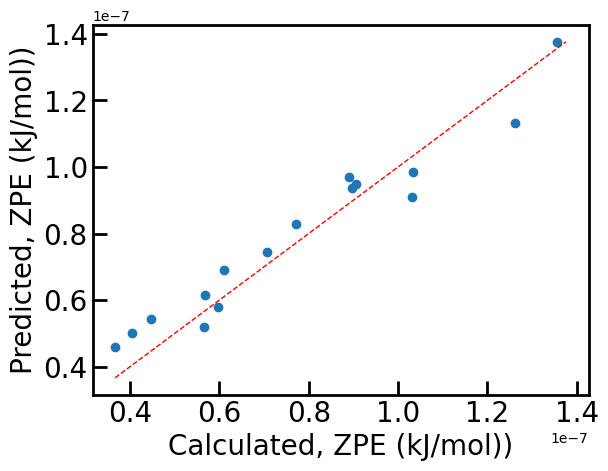

gpr2 -0.015954694145128068
RMSE:  0.28126009859130435
RMSE unscaled:  2.889533434088854e-08
----------------------------------------


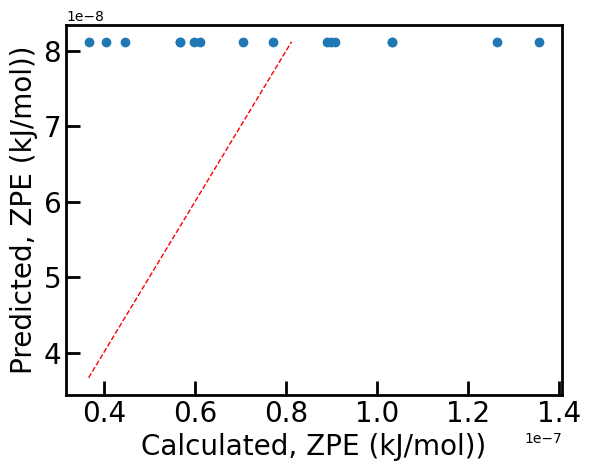

gpr3 0.9765716714724264
RMSE:  0.04271118360592346
RMSE unscaled:  4.387945309588935e-09
----------------------------------------


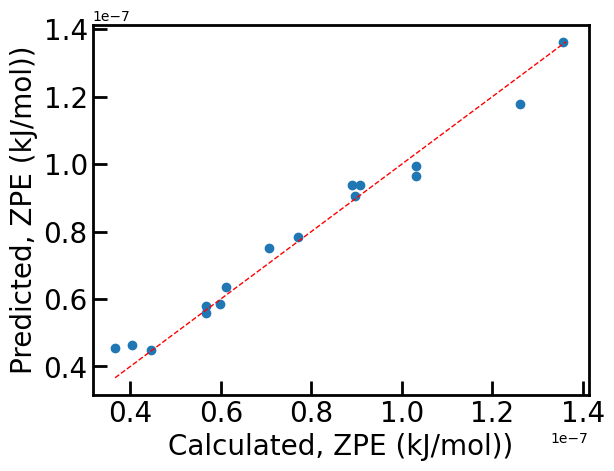

gpr4 0.9345011266533031
RMSE:  0.07141474155800455
RMSE unscaled:  7.3368133074048735e-09
----------------------------------------


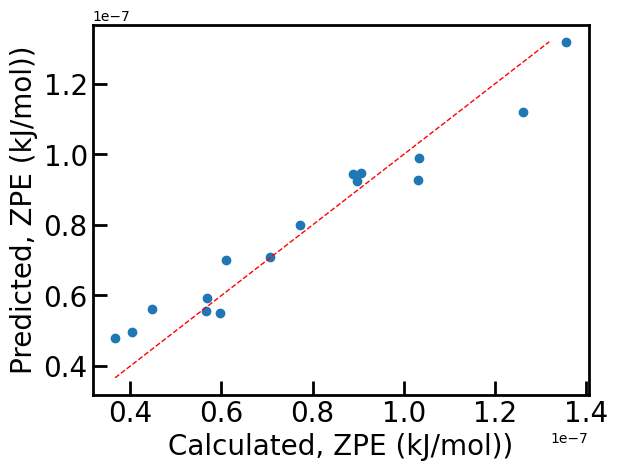

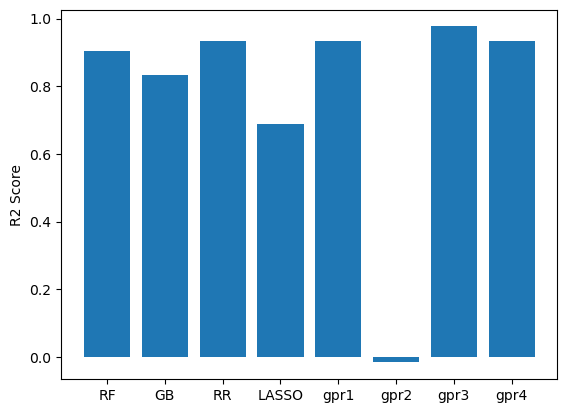

In [32]:
run_models()

## Feature selection


In [33]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature       Score
1   mean_A2B  116.020547
26      X_EA  102.827848
14       X_Z   85.709577
34    X_Rvdw   72.130297
4   mean_X2X   57.533597
32    A_Rvdw   43.418075
2   mean_A2X   41.138934
18     A_IEI   29.229299
9      E_coh   28.569477
30    A_ChiA   26.451810
23    X_IEII   20.118119
6    std_A2X   13.817586
27    A_ChiP   13.426174
24      A_EA   12.944525
44      B_Hf   12.679046
41     X_Rho   11.933612
7    std_B2X   11.458588
17       X_G   11.132373
38      B_MP   10.670370
47   X_Kappa    9.549651
37      A_MP    9.365081
46   B_Kappa    8.332838
13       B_Z    8.302309
11        OF    8.213709
45   A_Kappa    7.835195
12       A_Z    7.259730
36      B_Ra    6.424021
31    B_ChiA    5.442258
48     A_CvM    5.202146
40     B_Rho    5.027755


In [34]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 'X_Z', 'X_Rvdw', 'mean_X2X', 'A_Rvdw',
       'mean_A2X', 'A_IEI', 'E_coh', 'A_ChiA', 'X_IEII', 'std_A2X',
       'A_ChiP', 'A_EA', 'B_Hf', 'X_Rho', 'std_B2X', 'X_G', 'B_MP',
       'X_Kappa', 'A_MP', 'B_Kappa', 'B_Z', 'OF', 'A_Kappa', 'A_Z',
       'B_Ra', 'B_ChiA', 'A_CvM', 'B_Rho', 'X_MV', 'A_G', 'B_EA', 'A_B',
       'std_X2X', 'B_CvM', 'B_ChiP', 'TF', 'std_A2B', 'X_IEI'],
      dtype=object)

In [35]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(40,'Score')['Feature'].values]

RF 0.895960684376069
RMSE:  0.09000563440472466
RMSE unscaled:  9.246753847112195e-09
----------------------------------------


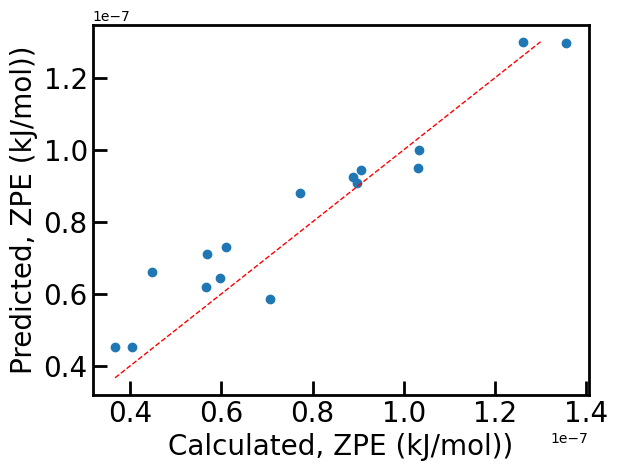

GB 0.869007109066741
RMSE:  0.10099382421792437
RMSE unscaled:  1.0375628579233077e-08
----------------------------------------


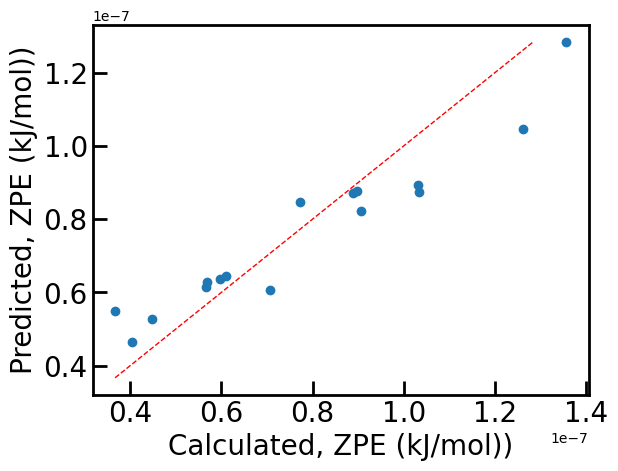

RR 0.9377549004329427
RMSE:  0.06961831970157124
RMSE unscaled:  7.152257409078368e-09
----------------------------------------


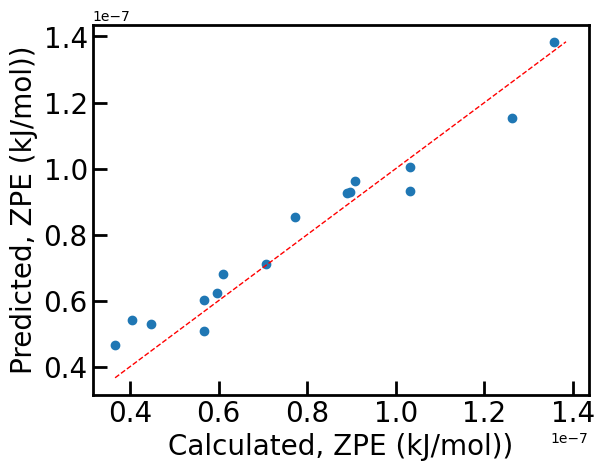

LASSO 0.687845144759145
RMSE:  0.1559035488416923
RMSE unscaled:  1.601679438809321e-08
----------------------------------------


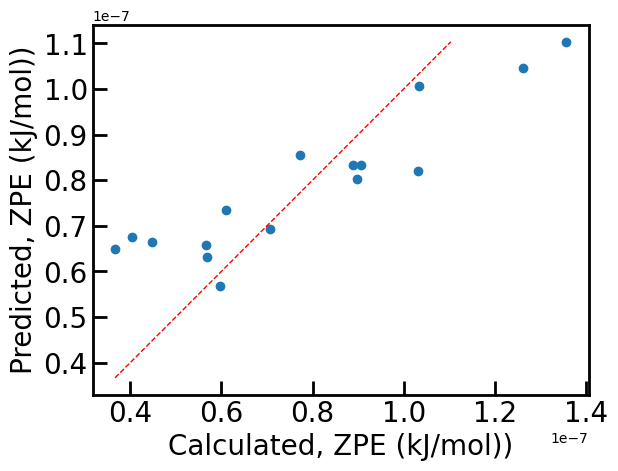

gpr1 0.9306619501705924
RMSE:  0.07347790502677584
RMSE unscaled:  7.54877297935493e-09
----------------------------------------


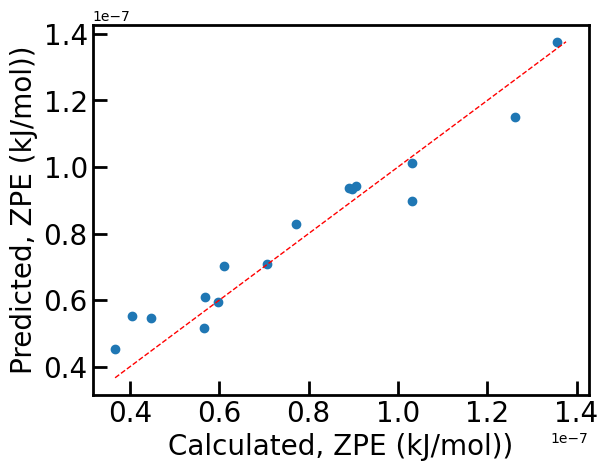

gpr2 -0.015954694655564206
RMSE:  0.2812600986619598
RMSE unscaled:  2.8895334348147342e-08
----------------------------------------


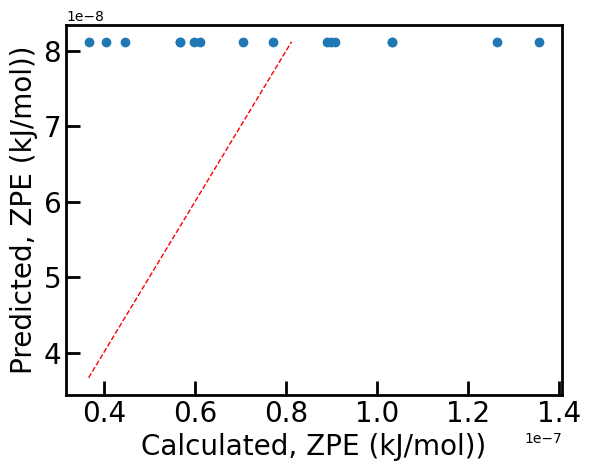

gpr3 0.9640681645670999
RMSE:  0.052894516904374106
RMSE unscaled:  5.434132884140729e-09
----------------------------------------


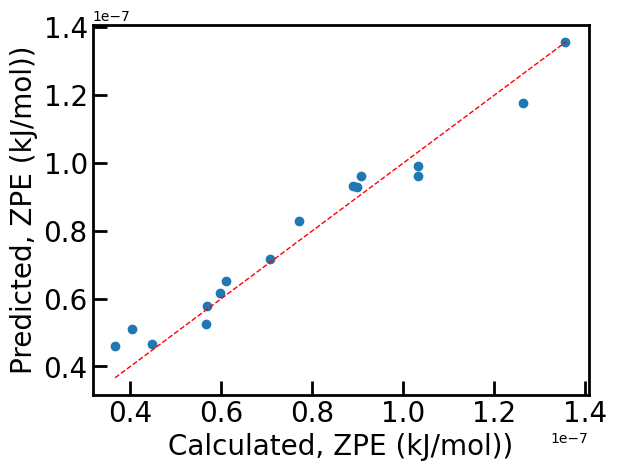

gpr4 0.9367239869267268
RMSE:  0.07019246717428285
RMSE unscaled:  7.2112426091407656e-09
----------------------------------------


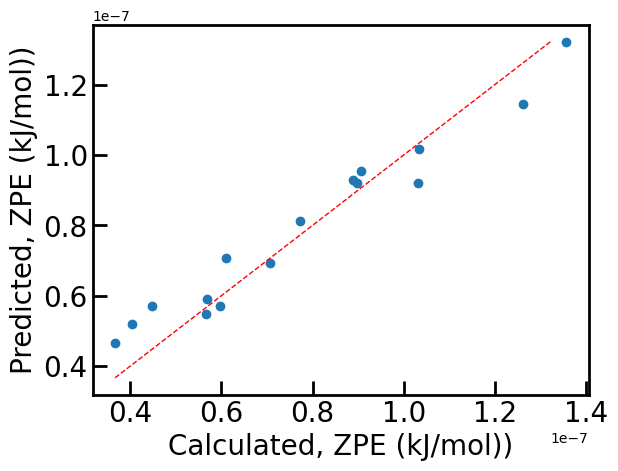

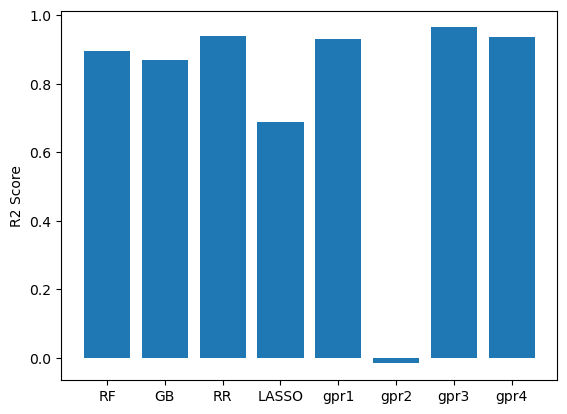

In [36]:
run_models()

In [37]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 'X_Z', 'X_Rvdw', 'mean_X2X', 'A_Rvdw',
       'mean_A2X', 'A_IEI', 'E_coh', 'A_ChiA', 'X_IEII', 'std_A2X',
       'A_ChiP', 'A_EA', 'B_Hf', 'X_Rho', 'std_B2X', 'X_G', 'B_MP',
       'X_Kappa', 'A_MP', 'B_Kappa', 'B_Z', 'OF', 'A_Kappa', 'A_Z',
       'B_Ra', 'B_ChiA', 'A_CvM', 'B_Rho'], dtype=object)

In [38]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(30,'Score')['Feature'].values]

RF 0.8982395675536496
RMSE:  0.08901443220734985
RMSE unscaled:  9.144922414086264e-09
----------------------------------------


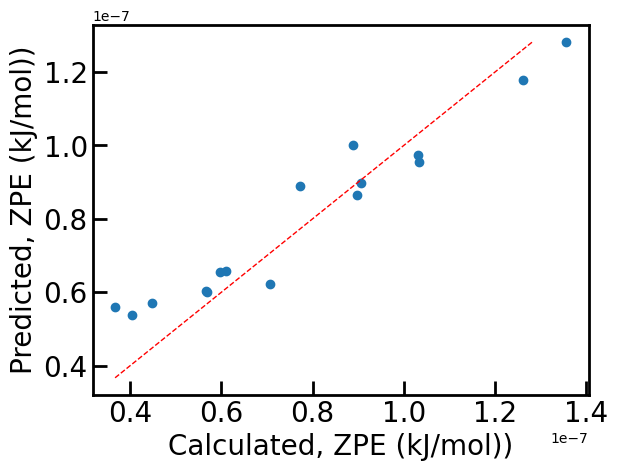

GB 0.8586787196079889
RMSE:  0.10489981826421868
RMSE unscaled:  1.077691196235952e-08
----------------------------------------


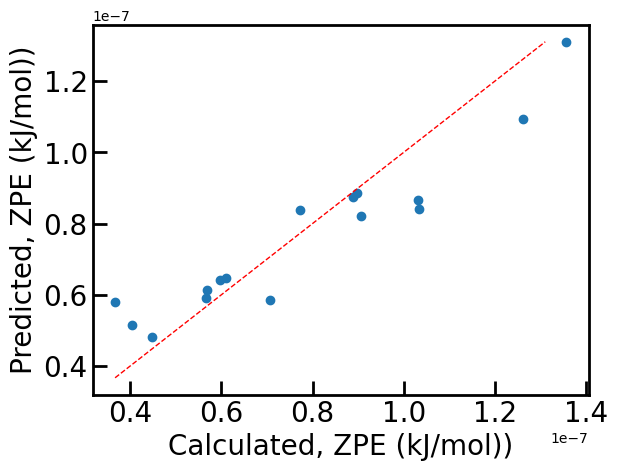

RR 0.9324972478498001
RMSE:  0.07249894618779329
RMSE unscaled:  7.448199371153675e-09
----------------------------------------


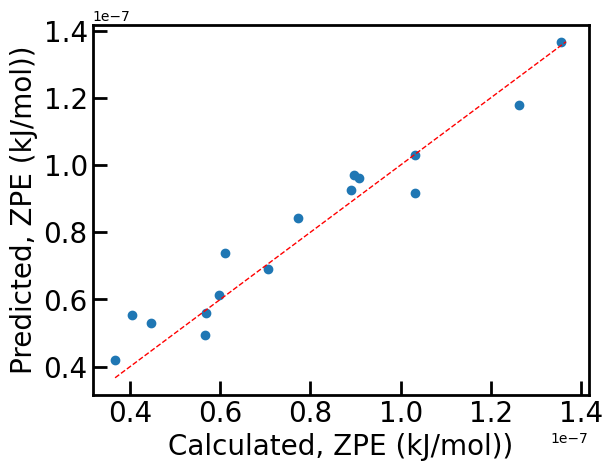

LASSO 0.687845144759145
RMSE:  0.1559035488416923
RMSE unscaled:  1.601679438809321e-08
----------------------------------------


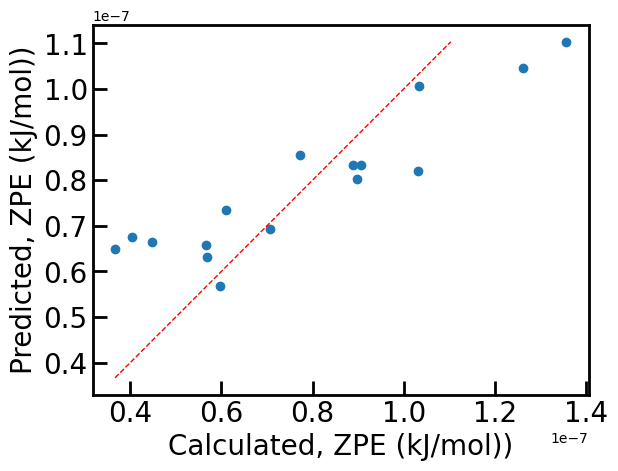

gpr1 0.9326124919381222
RMSE:  0.07243703283026581
RMSE unscaled:  7.44183868517339e-09
----------------------------------------


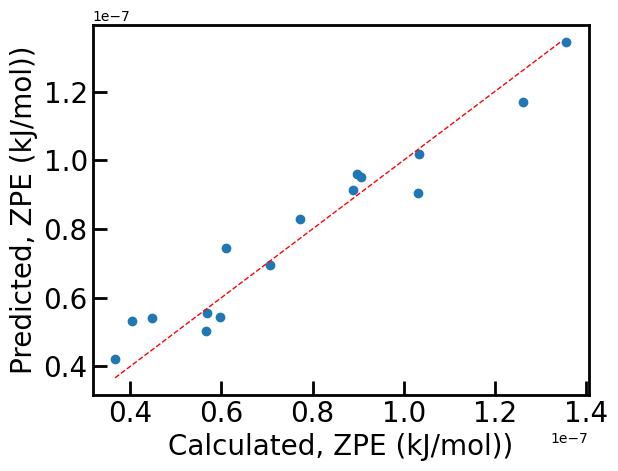

gpr2 -0.01595469224274093
RMSE:  0.28126009832797294
RMSE unscaled:  2.889533431383511e-08
----------------------------------------


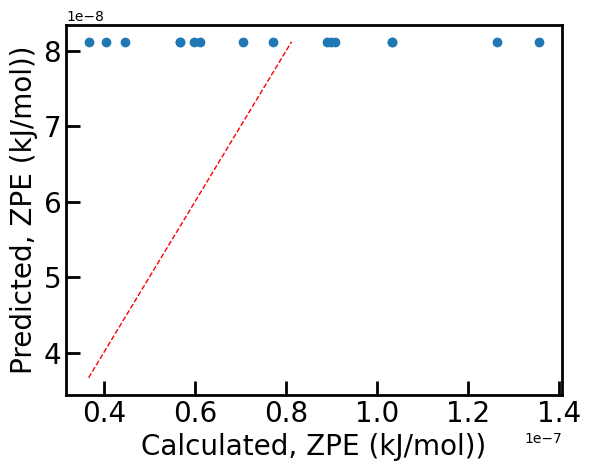

gpr3 0.9627769906194962
RMSE:  0.053836484748088595
RMSE unscaled:  5.530906212169911e-09
----------------------------------------


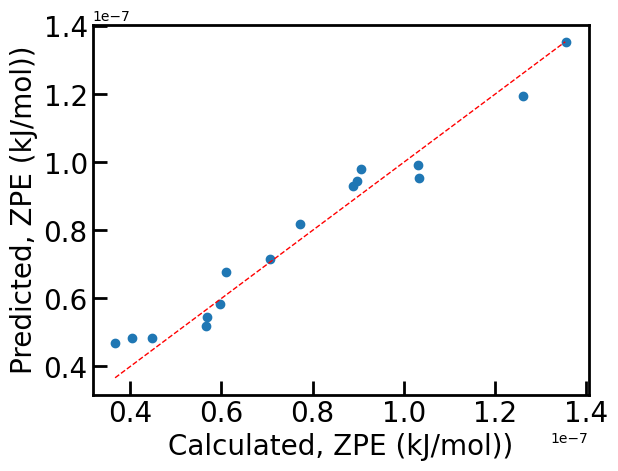

gpr4 0.9427414036942943
RMSE:  0.06677152612657739
RMSE unscaled:  6.859791280534233e-09
----------------------------------------


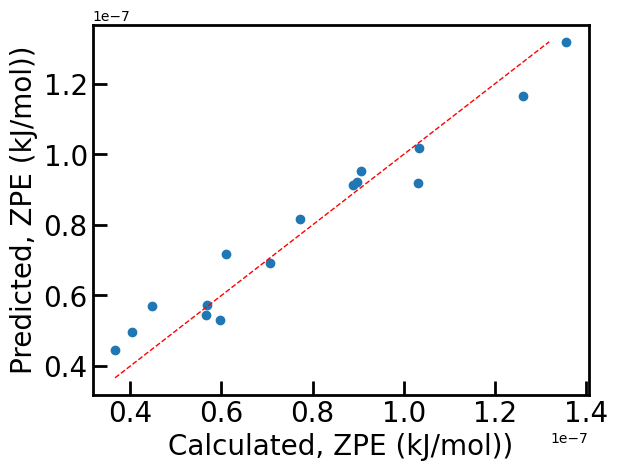

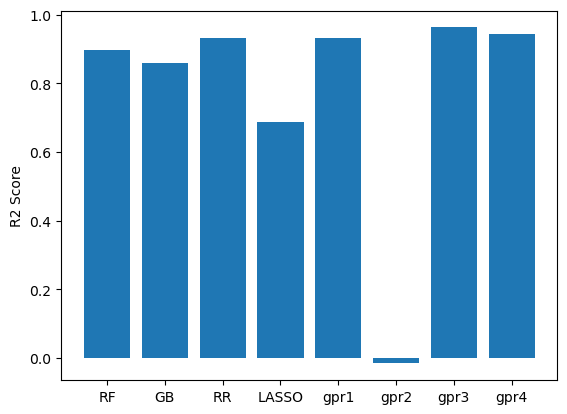

In [39]:
run_models()

In [40]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 'X_Z', 'X_Rvdw', 'mean_X2X', 'A_Rvdw',
       'mean_A2X', 'A_IEI', 'E_coh', 'A_ChiA', 'X_IEII', 'std_A2X',
       'A_ChiP', 'A_EA', 'B_Hf', 'X_Rho', 'std_B2X', 'X_G', 'B_MP',
       'X_Kappa'], dtype=object)

In [41]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(20,'Score')['Feature'].values]

RF 0.8632566259919352
RMSE:  0.10318678938263565
RMSE unscaled:  1.0600923464464315e-08
----------------------------------------


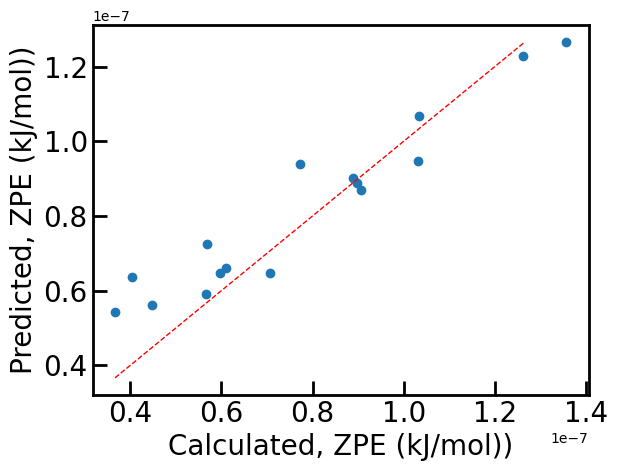

GB 0.8540658756597016
RMSE:  0.10659807996255614
RMSE unscaled:  1.0951383349582812e-08
----------------------------------------


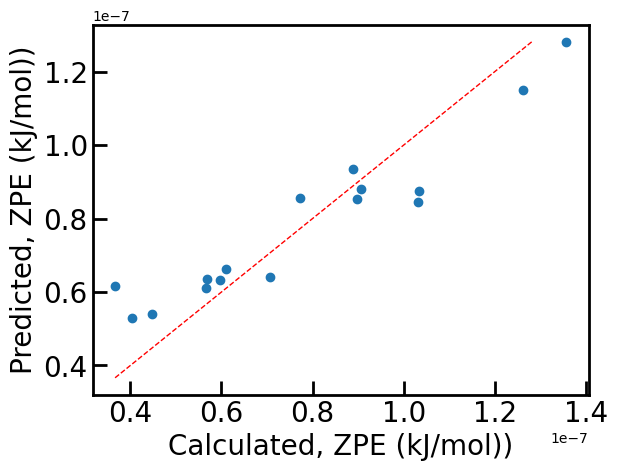

RR 0.9026045241051053
RMSE:  0.08708439640159055
RMSE unscaled:  8.946639649568217e-09
----------------------------------------


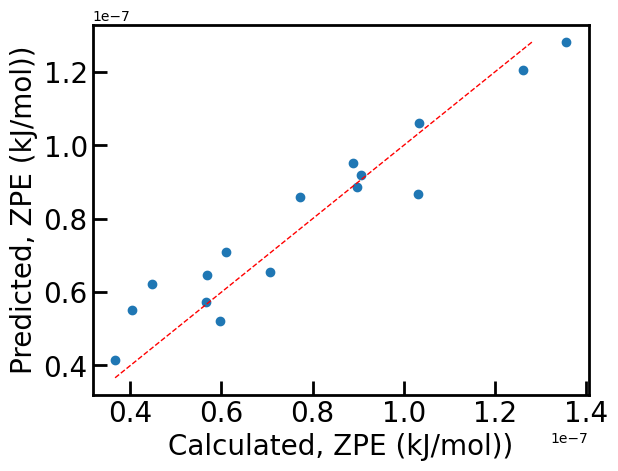

LASSO 0.6750648487766463
RMSE:  0.15906304856126438
RMSE unscaled:  1.6341386469245954e-08
----------------------------------------


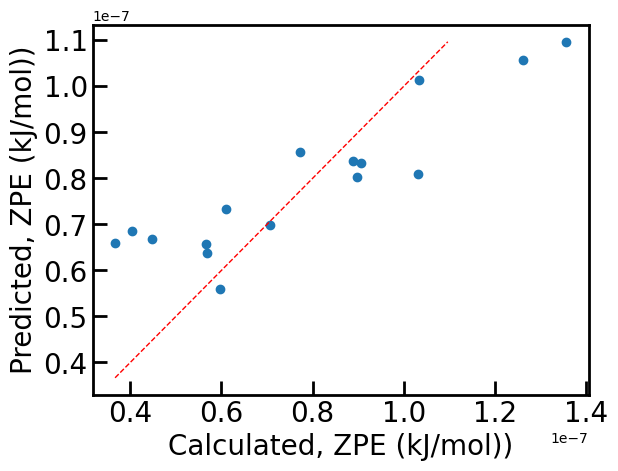

gpr1 0.8967721177585011
RMSE:  0.08965395707688135
RMSE unscaled:  9.210624179167693e-09
----------------------------------------


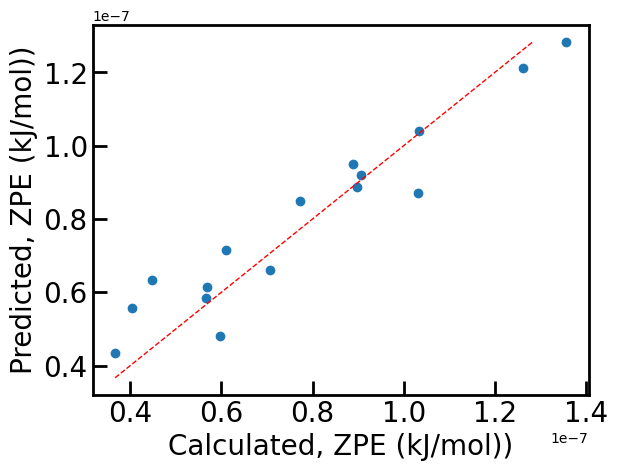

gpr2 -0.01595463641220185
RMSE:  0.28126009059982165
RMSE unscaled:  2.8895333519881346e-08
----------------------------------------


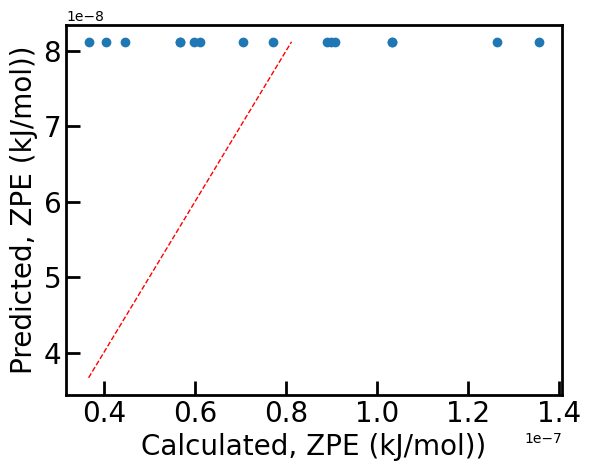

gpr3 0.9382291154530533
RMSE:  0.06935261868040471
RMSE unscaled:  7.12496054087781e-09
----------------------------------------


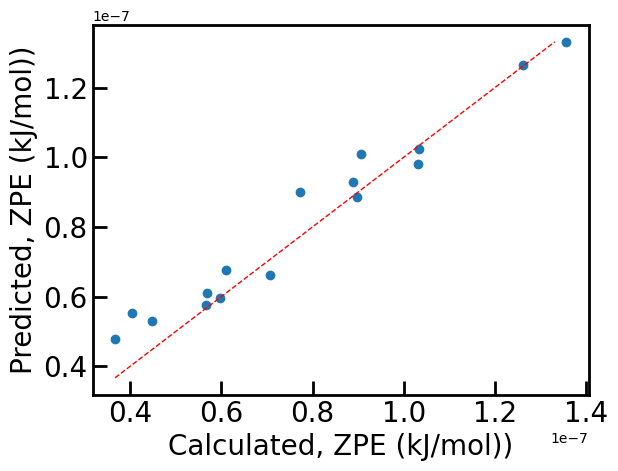

gpr4 0.9008412189933068
RMSE:  0.08786917394089364
RMSE unscaled:  9.02726398801849e-09
----------------------------------------


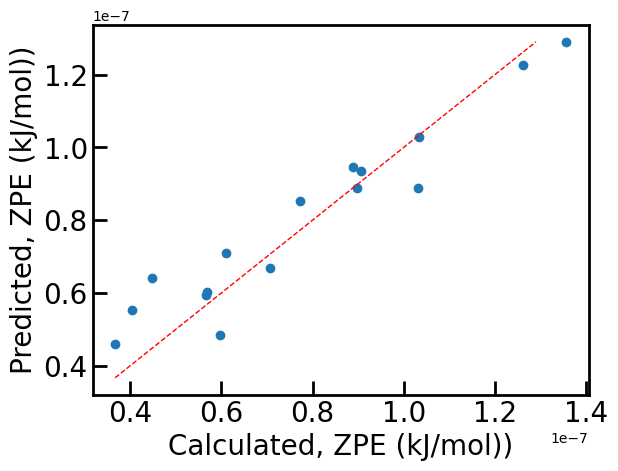

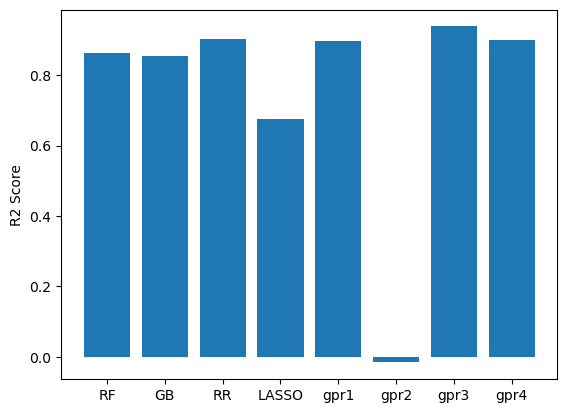

In [42]:
run_models()

In [43]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 'X_Z', 'X_Rvdw', 'mean_X2X', 'A_Rvdw',
       'mean_A2X', 'A_IEI', 'E_coh', 'A_ChiA'], dtype=object)

In [44]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(10,'Score')['Feature'].values]

RF 0.81263465700281
RMSE:  0.12078571799018964
RMSE unscaled:  1.2408954282570634e-08
----------------------------------------


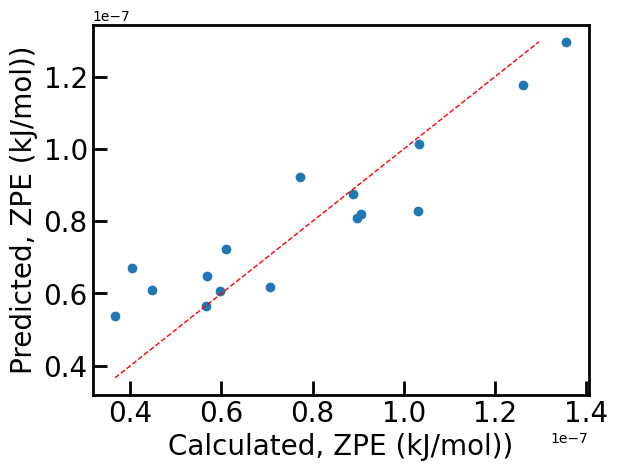

GB 0.827180896608642
RMSE:  0.11600236081343258
RMSE unscaled:  1.1917534754573082e-08
----------------------------------------


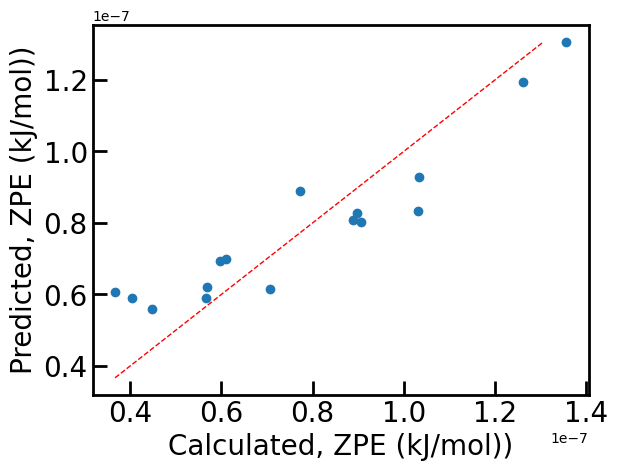

RR 0.8867552266492926
RMSE:  0.09390312328926208
RMSE unscaled:  9.647163450083473e-09
----------------------------------------


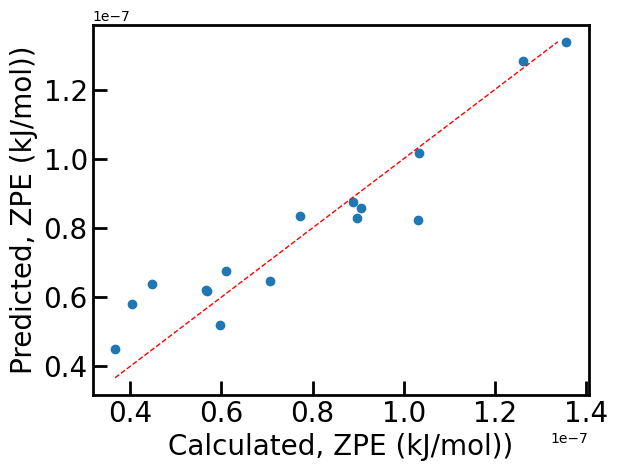

LASSO 0.6750648487766463
RMSE:  0.15906304856126438
RMSE unscaled:  1.6341386469245954e-08
----------------------------------------


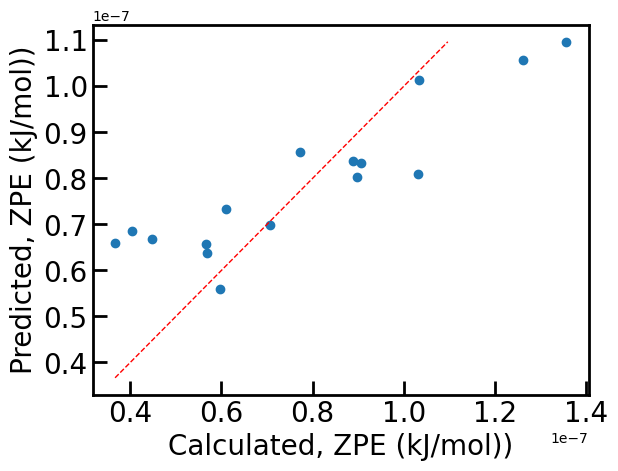

gpr1 0.8771942249863839
RMSE:  0.09778682583420649
RMSE unscaled:  1.0046156709627886e-08
----------------------------------------


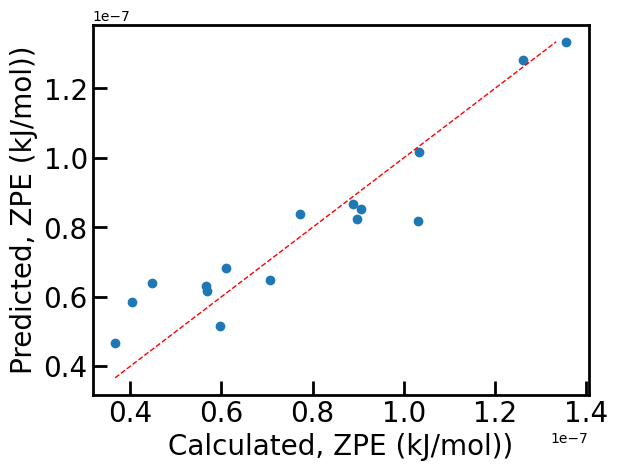

gpr2 -0.015954694438209405
RMSE:  0.2812600986318732
RMSE unscaled:  2.8895334345056386e-08
----------------------------------------


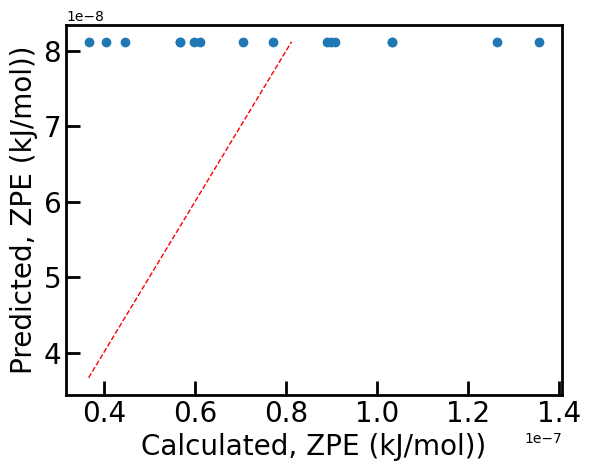

gpr3 0.9336497291672827
RMSE:  0.07187739087539326
RMSE unscaled:  7.384343713514685e-09
----------------------------------------


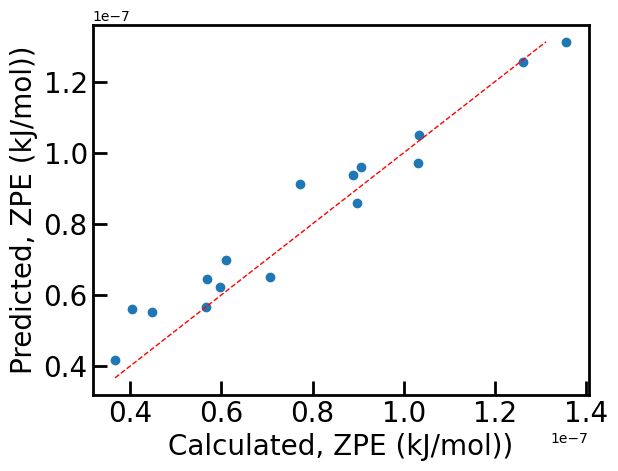

gpr4 0.8851239219192066
RMSE:  0.09457704793010284
RMSE unscaled:  9.71639928522393e-09
----------------------------------------


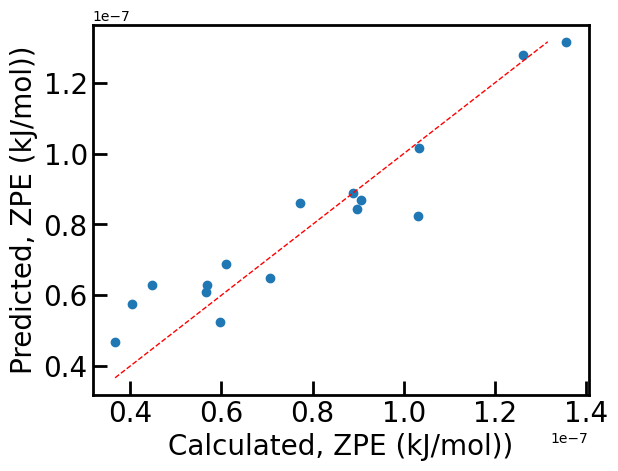

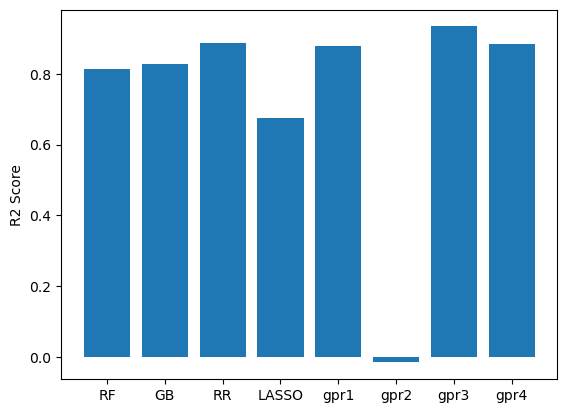

In [45]:
run_models()